# Libraries

In [35]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt, log
from scipy.linalg import expm
import itertools

In [36]:
import time

In [37]:
from IPython.display import clear_output

In [38]:
from Diff import *

In [39]:
!git clone https://github.com/equadratures/equadratures
clear_output()

In [40]:
with open("content/equadratures/equadratures/optimisation.py", "r") as file:
    fix_1 = file.read()

# Lines to modify in equadratures/optimisation.py

fix_1 = fix_1.replace('objective = lambda x: k*np.asscalar(f(x))', 'objective = lambda x: k*f(x).item()')
fix_1 = fix_1.replace('constraint = lambda x: np.asscalar(g(x))', 'constraint = lambda x: g(x).item()')
fix_1 = fix_1.replace('self.f_old = np.asscalar(self.f[ind_min])', 'self.f_old = self.f[ind_min].item()')
fix_1 = fix_1.replace('return np.asscalar(f)', 'return f.item()')
fix_1 = fix_1.replace('np.asscalar(my_poly.get_polyfit(x))', 'my_poly.get_polyfit(x).item()')
fix_1 = fix_1.replace('np.asscalar(my_poly.get_polyfit(np.dot(x,self.U)))', 'my_poly.get_polyfit(np.dot(x,self.U)).item()')
fix_1 = fix_1.replace('del_m = np.asscalar(my_poly.get_polyfit(self.s_old)) - m_new', 'del_m = np.ndarray.item(my_poly.get_polyfit(self.s_old)) - m_new')
fix_1 = fix_1.replace('del_m = np.asscalar(my_poly.get_polyfit(np.dot(self.s_old,self.U))) - m_new', 'del_m = np.ndarray.item(my_poly.get_polyfit(np.dot(self.s_old,self.U))) - m_new')

with open("content/equadratures/equadratures/optimisation.py", "w") as file:
    file.write(fix_1)

In [41]:
with open("content/equadratures/equadratures/sampling_methods/induced.py", "r") as file:
    fix_2 = file.read()

# Lines to modify in equadratures/sampling_methods/induced.py

fix_2 = fix_2.replace('F = np.asscalar(F)', 'F = F.item()')

with open("content/equadratures/equadratures/sampling_methods/induced.py", "w") as file:
    file.write(fix_2)

In [42]:
with open("content/equadratures/equadratures/solver.py", "r") as file:
    fix_3 = file.read()

# Lines to modify in equadratures/solver.py

fix_3 = fix_3.replace('fe = 0.5*(np.asscalar(np.dot(r.T,r)) - epsilon**2)', 'fe = 0.5*(np.dot(r.T,r).item() - epsilon**2)')
fix_3 = fix_3.replace('cqe = np.asscalar(np.dot(r.T,r)) - epsilon**2', 'cqe = np.dot(r.T,r).item() - epsilon**2')

with open("content/equadratures/equadratures/solver.py", "w") as file:
    file.write(fix_3)

In [43]:
with open("content/equadratures/equadratures/subspaces.py", "r") as file:
    fix_4 = file.read()

# Lines to modify in equadratures/subspaces.py

fix_4 = fix_4.replace('dV[:,l,:,j] = np.asscalar(vectord[l])*(X.T*current[:,j])', 'dV[:,l,:,j] = vectord[l].item()*(X.T*current[:,j])')

with open("content/equadratures/equadratures/subspaces.py", "w") as file:
    file.write(fix_4)

In [44]:
import sys
sys.path.append('content/equadratures')

import equadratures as eq

# Functions

In [45]:
def ed_diff_function(y):
  y = (y+1)/2
  c_bar = construct_cbar(y)

  C = construct_C(c_bar, sizes, n)
  D = construct_D(A, C, n)
  M = C*A - D

  diff = ed_diffusion(M, x0, tau=0.01, T=1)

  return diff[2,-1]

In [46]:
def ted_diff_function(y):
  y = (y+1)/2
  c_bar = construct_cbar(y)

  C = construct_C(c_bar, sizes, n)
  M_t = construct_Mt(A, C, sizes, alpha=[2,3,4])

  diff = RK4_t(x0, 0.01, M_t)

  return diff[2,-1]

In [47]:
def get_average_rmse(m, my_method, dim=3, simuls=5, basis='total-order', ord=4):
  errors = np.array([])
  my_param_list = [eq.Parameter(distribution='uniform', order=ord, lower=-1.0, upper=1.0) for i in range(dim)]

  for j in range(simuls):
    if basis == 'hyperbolic-basis':
      my_basis = eq.Basis(basis, q=0.5)
    else:
      my_basis = eq.Basis(basis)

    X_train = np.random.uniform(-1, 1, size=(m, dim))
    y_train = eq.evaluate_model(X_train, ed_diff_function)
    my_poly = eq.Poly(parameters=my_param_list, basis=my_basis, method=my_method, \
                      sampling_args={'mesh':'user-defined', 'sample-points':X_train, \
                                    'sample-outputs':y_train})
    my_poly.set_model()

    test_pts = np.random.uniform(-1, 1, size=(1000, dim))
    test_evals = eq.evaluate_model(test_pts, ed_diff_function)
    train_r2, test_r2 = my_poly.get_polyscore(X_test=test_pts, y_test=test_evals, metric='rmse')
    train_r2, test_r2

    errors = np.append(errors, test_r2)

  return np.mean(errors)

In [48]:
def get_average_rmse_TED(m, my_method, dim=3, simuls=5, basis='total-order', ord=4):
  errors = np.array([])
  my_param_list = [eq.Parameter(distribution='uniform', order=ord, lower=-1.0, upper=1.0) for i in range(dim)]

  for j in range(simuls):
    if basis == 'hyperbolic-basis':
      my_basis = eq.Basis(basis, q=0.5)
    else:
      my_basis = eq.Basis(basis)
    X_train = np.random.uniform(-1, 1, size=(m, dim))
    y_train = eq.evaluate_model(X_train, ted_diff_function)
    my_poly = eq.Poly(parameters=my_param_list, basis=my_basis, method=my_method, \
                      sampling_args={'mesh':'user-defined', 'sample-points':X_train, \
                                    'sample-outputs':y_train})
    my_poly.set_model()

    test_pts = np.random.uniform(-1, 1, size=(500, dim))
    test_evals = eq.evaluate_model(test_pts, ted_diff_function)
    train_r2, test_r2 = my_poly.get_polyscore(X_test=test_pts, y_test=test_evals, metric='rmse')
    train_r2, test_r2

    errors = np.append(errors, test_r2)

  return np.mean(errors)

In [49]:
def conv(x, method, dim=3, simuls=5, basis='total-order', ord=4, verbose=False):
  Y = []

  for element in x:
    if verbose:
      start = time.time()
    Y.append(get_average_rmse(element, method, dim=dim, simuls=simuls, ord=ord, basis=basis))
    if verbose:
      end = time.time()
      print('m={} w/ {}, done: {} seconds.'.format(element, method, end-start))

  return Y

In [50]:
def conv_TED(x, method, dim=3, simuls=5, basis='total-order', ord=4, verbose=False):
  Y = []

  for element in x:
    if verbose:
      start = time.time()
    Y.append(get_average_rmse_TED(element, method, dim=dim, simuls=simuls, ord=ord, basis=basis))
    if verbose:
      end = time.time()
      print('m={} w/ {}, done: {} seconds.'.format(element, method, end-start))

  return Y

# Graph initialization

In [51]:
sizes = [5, 5]
probs = [[1, 0.04], [0.04, 1]]

#sizes = [5, 5, 5]
#probs = [[1, 0.04, 0.04], [0.04, 1, 0.04], [0.04, 0.04, 1]]

#sizes = [6, 10, 4, 10]
#probs = [[1, 0.04, 0.04, 0.04], [0.04, 1, 0.04, 0.04], [0.04, 0.04, 1, 0.04], [0.04, 0.04, 0.04, 1]]

G = nx.stochastic_block_model(sizes, probs, seed=0)
pos = nx.spring_layout(G)
A = nx.adjacency_matrix(G).todense()
L = nx.laplacian_matrix(G).toarray()

n = G.number_of_nodes()
x0 = np.zeros(n)
activ = np.random.choice(n, int(0.2*n))
x0[activ] = 100

# Polynomial approximation

In [52]:
K = len(sizes)
d = int(K*(K+1)/2)
d

3

In [53]:
nb_samples = [i*50 for i in range(1,7)]

In [54]:
# Convergence plot for ED diffusion
# For method, choose 'least-squares' or 'compressed-sensing'
# For basis, choose 'tensor-grid', 'total-order' or 'hyperbolic-basis'
# PS: 'tensor-grid' is not very good, and takes even longer to run

#method = 'least-squares'
basis = 'total-order'
order = 8

In [55]:
# (!!!) This is the part that takes the most time
# 2 minutes to +2 hours, depending on the method, basis, order, number of rounds (simuls), etc.

ls = conv(nb_samples, 'least-squares', dim=d, simuls=1, basis=basis, ord=order)
cs = conv(nb_samples, 'compressed-sensing', dim=d, simuls=1, basis=basis, ord=order)

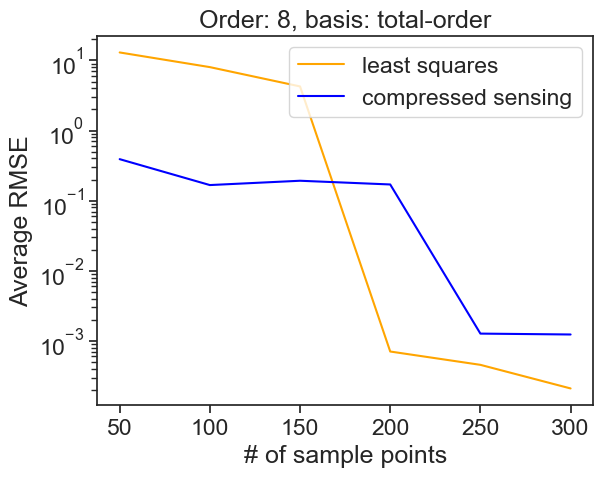

In [56]:
plt.plot(nb_samples, ls, 'orange', label='least squares')
plt.plot(nb_samples, cs, 'blue', label='compressed sensing')
plt.yscale('log')
plt.xlabel('# of sample points')
plt.ylabel('Average RMSE')
plt.title('Order: {}, basis: {}'.format(order, basis))
plt.legend()
plt.show()